# The EM algorithm for Hawkes processes

Here we explore the optimisation algorithm for parameter estimation given in

1. Mohler et al. "Randomized Controlled Field Trials of Predictive Policing". Journal of the American Statistical Association (2015) DOI:10.1080/01621459.2015.1077710
2. Lewis, Mohler, "A Nonparametric EM algorithm for Multiscale Hawkes Processes", preprint (2011) see http://math.scu.edu/~gmohler/EM_paper.pdf
3. Laub et al "Hawkes Processes" arXiv:150702822v1 [math.PR]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Checking the simulation

In [2]:
import open_cp.sources.sepp as source_sepp
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=0.05))

### Background rate

Should be a homogeneous Poisson process of rate 0.1

In [3]:
totality = []
trials = 50000
for _ in range(trials):
    result = process.sample_with_details(0,100)
    totality.extend(result.backgrounds)

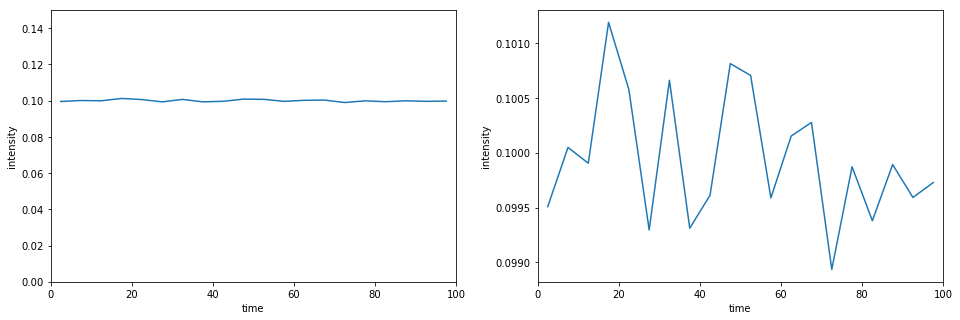

In [4]:
bins = np.linspace(0, 100, 21)
counts = np.histogram(totality, bins)[0]
counts = counts / (trials * (bins[1] - bins[0]))

fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].plot((bins[:-1] + bins[1:])/2, counts)
ax[0].set(xlim=[0,100], ylim=[0,.15])
ax[1].plot((bins[:-1] + bins[1:])/2, counts)
ax[1].set(xlim=[0,100])
for i in range(2):
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("intensity")
None

### Aftershocks

Should be exponential, with an "exponential weight" on 0.05, and "intensity" of 1.0.  So the conditional intensity function should be $\theta \omega e^{-\omega t}$ with $\theta=1, \omega=0.05$.

In [5]:
totality = []
trials = 10000
for _ in range(trials):
    result = process.sample_with_details(0,100)
    totality.extend(result.trigger_deltas)

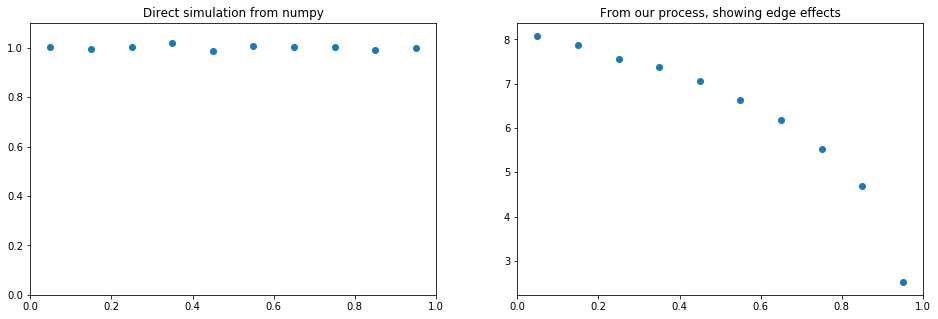

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(16,5))

bins = np.linspace(0,1,11)
xcoords = (bins[:-1] + bins[1:]) / 2

y = np.random.exponential(1 / 0.05, size=100000)
x = 1 - np.exp(-0.05 * np.asarray(y))
c = np.histogram(x, bins)[0]
ax[0].scatter(xcoords, c / 10000)
ax[0].set(xlim=[0,1], ylim=[0,1.1], title="Direct simulation from numpy")

y = np.asarray(totality)
x = 1 - np.exp(-0.05 * np.asarray(y))
c = np.histogram(x, bins)[0]
ax[1].scatter(xcoords, c / trials * 10)
ax[1].set(xlim=[0,1], title="From our process, showing edge effects")
None

We only sample the process in a finite time interval, so we'll miss aftershocks which occur after the end of our time window.  
To correct for this, using the extra (normally hidden) information we have about our simulation, we can discard aftershocks which occur near the end of our time window.

In [7]:
totality = []
trials = 1000
total_points = 0
for _ in range(trials):
    result = process.sample_with_details(0,1000)
    mask = result.trigger_points <= 900
    totality.extend( result.trigger_deltas[mask] )
    count = np.sum(result.points <= 900)
    total_points += count

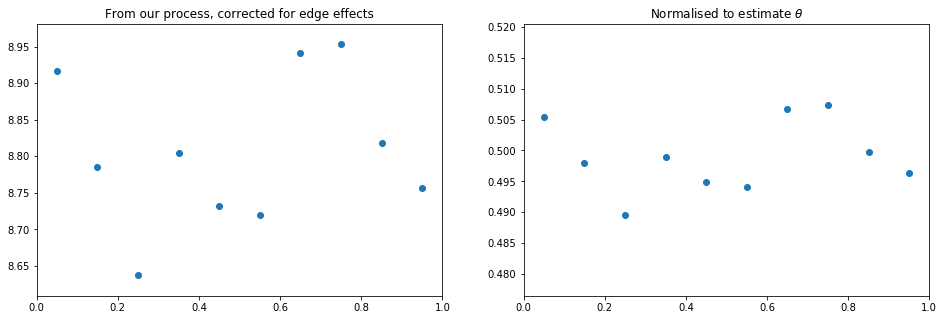

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(16,5))

y = np.asarray(totality)
x = 1 - np.exp(-0.05 * np.asarray(y))
c = np.histogram(x, bins)[0]
ax[0].scatter(xcoords, c / trials)
ax[0].set(xlim=[0,1], title="From our process, corrected for edge effects")
scale = 1 / ((bins[1] - bins[0]) * total_points)
ax[1].scatter(xcoords, c * scale)
ax[1].set(xlim=[0,1], title="Normalised to estimate $\\theta$")
None

To get the normalisation correct above, we need to think about what the "intensity" parameter $\theta$ represents.

- Each background event gives rise to $n$ aftershock events, where $n$ is distributed as a Poisson random variable with mean $\theta$.
- Each of these initial aftershocks gives rise to further aftershocks, again with the same distribution.
- And so on.

The total number of events, counting also the initial event, is then
$$ 1 + \theta + \theta^2 + \cdots = \frac{1}{1-\theta} $$
supposing $\theta<1$.  This is a standard result in the theory of Branching Processes, see e.g. [Lectures notes, page 9](http://wwwf.imperial.ac.uk/~ejm/M3S4/NOTES2.PDF)  So let $\alpha$ be the count of aftershock events, and $\beta$ the count of background events, $\alpha + \beta$ is the total number of events.  Then

$$ \frac{\alpha}{\beta} = \frac{1}{1-\theta} - 1 = \frac{\theta}{1-\theta} \implies
\theta = \frac{\alpha / \beta}{1+\alpha/\beta} =\frac{\alpha}{\alpha+\beta} $$

# The EM algorithm

Here we implement the "EM" algorithm described by Mohler et al (2015).

In [9]:
total_time = 10000
result = process.sample_with_details(0, total_time)
points = result.points
points.shape, result.trigger_deltas.shape

((2072,), (1065,))

In [10]:
def p_matrix_col(points, col, theta=0.5, omega=0.05, mu=0.1):
    p = np.empty(col + 1)
    p[col] = mu
    dt = points[col] - points[0:col]
    p[0:col] = theta * omega * np.exp(-omega * dt)
    return p, np.sum(p), dt

def m_step(points, total_time, theta=0.5, omega=0.05, mu=0.1):
    omega_1, omega_2, mu_e = 0.0, 0.0, 0.0
    for col in range(len(points)):
        p, norm, dt = p_matrix_col(points, col, theta, omega, mu)
        wp = p[0:col] * dt
        omega_1 += np.sum(p[0:col]) / norm
        omega_2 += np.sum(wp) / norm
        mu_e += p[-1] / norm

    return omega_1 / len(points), omega_1 / omega_2, mu_e / total_time

theta, omega, mu = m_step(points, total_time)
theta, omega, mu

(0.50565576211380503, 0.04957550437953518, 0.10242812609001969)

In [11]:
def apply_algorithm(points, total_time, steps=200, theta_in=0.5, omega_in=0.05, mu_in=0.1,
                    convergence_criteria=None, func=m_step):
    theta, omega, mu = theta_in, omega_in, mu_in
    thetas, omegas, mus = [theta], [omega], [mu]
    for _ in range(steps):
        theta, omega, mu = func(points, total_time, theta, omega, mu)
        diff = max(abs(thetas[-1] - theta), abs(omegas[-1] - omega), abs(mus[-1] - mu))
        thetas.append(theta)
        omegas.append(omega)
        mus.append(mu)
        if convergence_criteria is not None and diff <= convergence_criteria:
            break
        
    return thetas, omegas, mus

In [12]:
thetas, omegas, mus = apply_algorithm(points, total_time, 100)
thetas[-1], omegas[-1], mus[-1]

(0.4817409710361486, 0.041484993953676004, 0.10738327080131001)

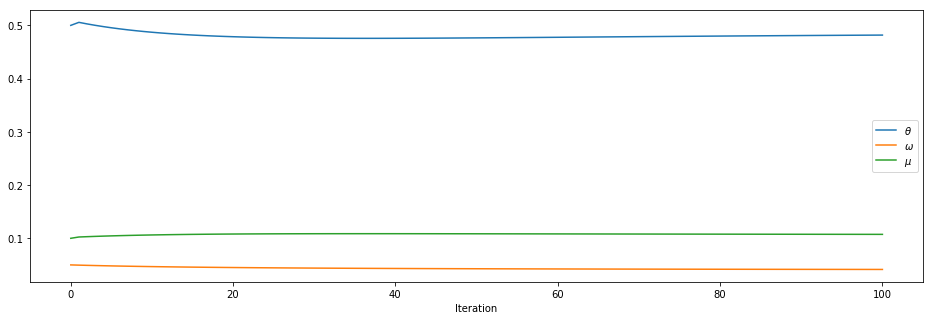

In [13]:
def plot_convergence(thetas, omegas, mus, inv_omega=False):
    fig, ax = plt.subplots(figsize=(16,5))

    x = list(range(len(thetas)))
    ax.plot(x, thetas)
    legend_txt = ["$\\theta$"]
    if inv_omega:
        legend_txt.append("$\\omega^{-1}$")
        ax.plot(x, 1 / np.asarray(omegas))
    else:
        legend_txt.append("$\\omega$")
        ax.plot(x, omegas)
    ax.plot(x, mus)
    legend_txt.append("$\\mu$")
    ax.legend(legend_txt)
    ax.set(xlabel="Iteration")

plot_convergence(thetas, omegas, mus)

For a largish sample size, this is typical behaviour-- we converge to an estimate which under-estimates $\theta$ and slightly over-estimates $\omega$ and $\mu$.

- So we think there are slightly more background events than there really are
- For the aftershocks, we underestimate the mean value of the exponential (so believe aftershocks occur closer in time than they really do) and underestimate the total aftershock intensity.

I cannot rigourously justisfy this, but I believe this is due to edge effects-- events which occur near the end of our time window are likely to trigger aftershocks which we do not observe (because they fall after the time window) and so we underestimate the intensity of aftershocks, and so compensate by overestimating the background rate.

It must be said that with repeated runs, you can also get the opposite behaviour-- $\theta$ being over-estimated.

### For a small sample

In [14]:
total_time = 1000
result = process.sample_with_details(0, total_time)
points = result.points
points.shape, result.trigger_deltas.shape

((205,), (104,))

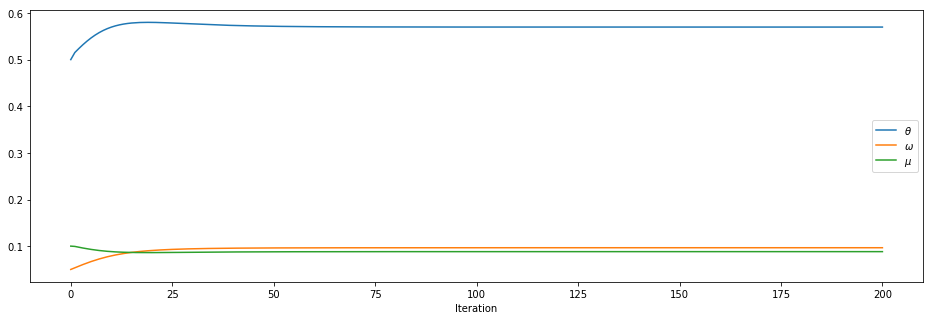

In [15]:
plot_convergence(*apply_algorithm(points, total_time, 200))

This is a slightly extreme graph, but it can certainly occur.

## Using a window of data

If our model is correct, then note that "real-world" will not start from time 0, but will instead be a window onto an on-going process.

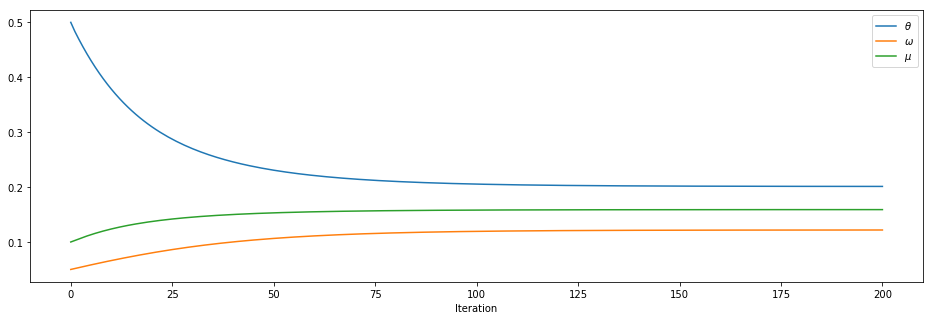

In [16]:
total_time = 2000
result = process.sample_with_details(0, total_time)
points = result.points
points = points[points>=1000]

plot_convergence(*apply_algorithm(points, 1000, 200))

This is a typical graph, though more extreme behaviour can be observed as well!

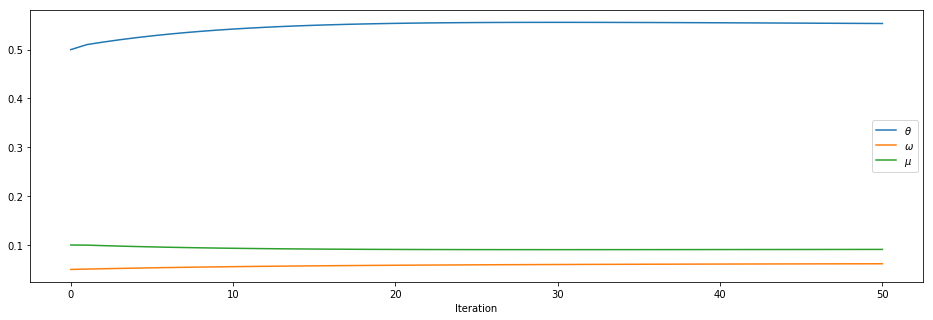

In [17]:
total_time = 11000
result = process.sample_with_details(0, total_time)
points = result.points
points = points[points>=1000]

plot_convergence(*apply_algorithm(points, 10000, 50))

# Choosing different parameters

The above work is all performed with $\mu=0.1, \omega=0.05, \theta=0.5$.  The choice of $\omega$ is problematic, as this means that the average time between event and aftershock is $20$ time units, 2 times longer than the expected time to the next background event.

So let's repeat the work, but with $\omega=1$ say.

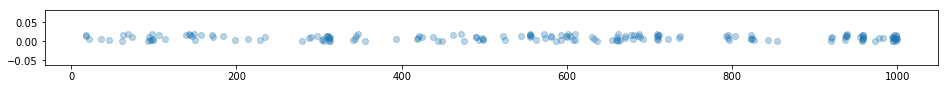

In [18]:
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=1))

points = process.sample(0, 1000)

fig, ax = plt.subplots(figsize=(16,1))
ax.scatter(points, np.random.random(len(points))*.02, alpha=0.3)
None

In [19]:
total_time = 10000
result = process.sample_with_details(0, total_time)
points = result.points
points.shape, result.trigger_deltas.shape

((1949,), (957,))

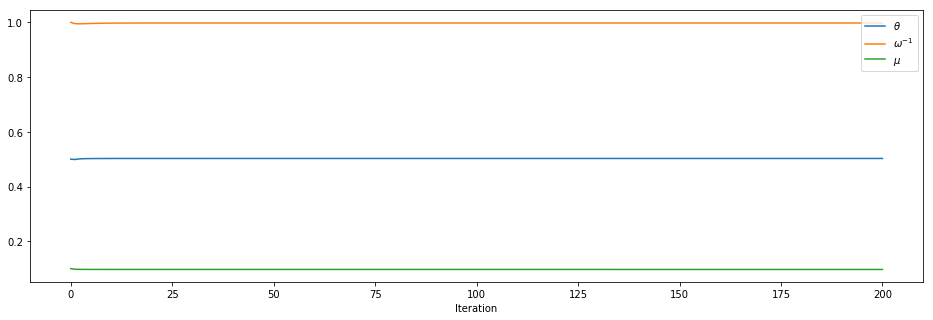

In [20]:
plot_convergence(*apply_algorithm(points, total_time, 200, theta_in=0.5, omega_in=1, mu_in=0.1), True)

Finally try with $\omega=10$ and a small(er) sample.

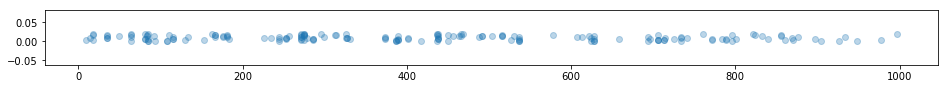

In [21]:
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=10))

points = process.sample(0, 1000)

fig, ax = plt.subplots(figsize=(16,1))
ax.scatter(points, np.random.random(len(points))*.02, alpha=0.3)
None

In [22]:
total_time = 1000
result = process.sample_with_details(0, total_time)
points = result.points
points.shape, result.trigger_deltas.shape

((185,), (78,))

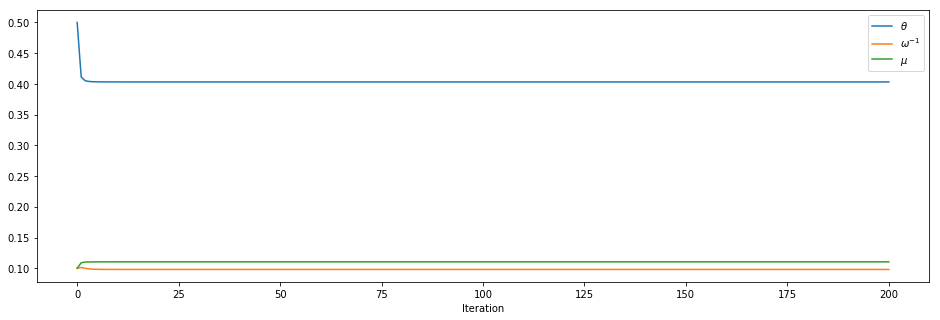

In [23]:
plot_convergence(*apply_algorithm(points, total_time, 200, theta_in=0.5, omega_in=10, mu_in=0.1), True)

# Recreation of Lewis and Mohler

The EM algorithm which we're using originates in:

Lewis, Mohler, "A Nonparametric EM algorithm for Multiscale Hawkes Processes", preprint 2010, see http://math.scu.edu/~gmohler/EM_paper.pdf

In Figure 1 of that paper, they carry out simulations (10 times) with $\mu=1, \theta=0.5$ time in $[0,2000]$ and with $\omega^{-1} = 0.01, 0.1, 1$ and $10$.

By comparison, if we rescale to $\mu=0.1$ as used above, the paper considers time in $[0,20000]$ and $\omega^{-1} = 0.001, 0.01, 0.1$ and $1$ which are more extreme values than we considered before!

As in the paper, here we run the algorithm until the difference (in $L^\infty$ norm) between iterations is less than $10^{-5}$.  We are only varying $\omega$ which controls the "scale" of the aftershocks.  As $\omega^{-1}$ increases, aftershocks becomes more spread-out in time, and thus, at least intuitively, it becomes harder to tell background events apart from aftershock events.

In [24]:
all_results_dict = {}
for omega_inv in [0.01, 0.1, 1, 10]:
    results = []
    for _ in range(10):
        process = source_sepp.SelfExcitingPointProcess(
            background_sampler = source_sepp.HomogeneousPoissonSampler(rate=1),
            trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=1/omega_inv))
        points = process.sample(0, 2000)
        convergents = apply_algorithm(points, 2000, 2000, theta_in=0.5, omega_in=1/omega_inv, mu_in=1,
                                 convergence_criteria = 10**(-5), func=m_step)
        convergents = np.asarray(convergents)
        # (theta, omega, mu), iterations
        results.append((convergents[:,-1], convergents.shape[-1]))
    all_results_dict[omega_inv] = results

In [25]:
thetas = {key: [result[0][0] for result in all_results_dict[key]] for key in all_results_dict}
mus = {key: [result[0][2] for result in all_results_dict[key]] for key in all_results_dict}

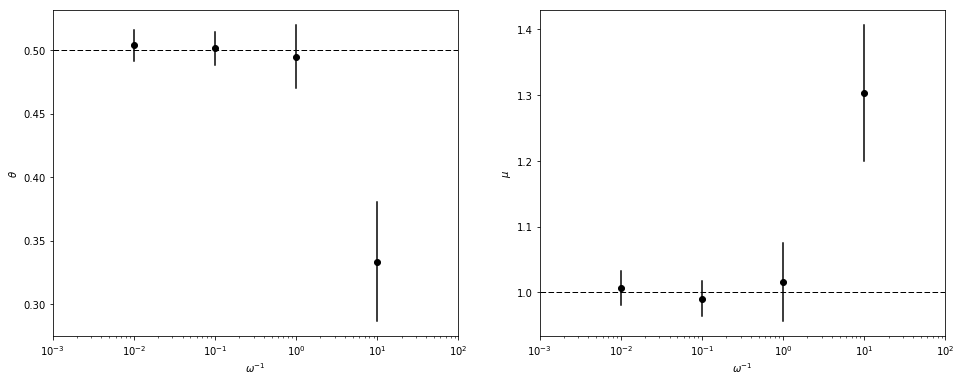

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

def plot(ax, data, true_value):
    x = list(data.keys())
    y = np.asarray([ np.mean(data[k]) for k in x ])
    ax.scatter(x, y, color="black")
    yy = np.asarray([ np.std(data[k], ddof=1) for k in x ])
    for x, y, dy in zip(x,y,yy):
        ax.plot([x]*2, [y-dy,y+dy], color="black")
    ax.plot([0.001,100], [true_value]*2, color="black", linestyle="--", linewidth=1)
    ax.set(xscale="log", xlim=[0.001,100])

plot(ax[0], thetas, 0.5)
plot(ax[1], mus, 1)
ax[0].set(xlabel="$\\omega^{-1}$", ylabel="$\\theta$")
ax[1].set(xlabel="$\\omega^{-1}$", ylabel="$\\mu$")
None

Except when $\omega^{-1}=10$ these look like the graphs from the paper.

Reading more closely, we see from the paper:

> To investigate the convergence of (14) we simulate realizations ...  run the EM algorithm (with boundary correction)

This is misleading, as (14) refers to the uncorrected algorithm.  By "boundary correction" we mean computing the likelihood without applying certain approximations.  This leads to a variant on the "M step":

$$ \theta = \frac{\sum_{i<j} p_{ij}}{n - \sum_{i=1}^n e^{-\omega (T-t_i)}}, \qquad
\omega = \frac{\sum_{i<j} p_{ij}}{\sum_{i<j}(t_j-t_i)p_{ij} + \theta \sum_{i=1}^n(T-t_i)e^{-\omega(T-t_i)}} $$

In [27]:
def corrected_m_step(points, total_time, theta=0.5, omega=0.05, mu=0.1):
    omega_1, omega_2, mu_e = 0.0, 0.0, 0.0
    for col in range(len(points)):
        p, norm, dt = p_matrix_col(points, col, theta, omega, mu)
        wp = p[0:col] * dt
        omega_1 += np.sum(p[0:col]) / norm
        omega_2 += np.sum(wp) / norm
        mu_e += p[-1] / norm

    from_end = total_time - points
    exp_from_end = np.exp(-omega * from_end)
    corrected_n = len(points) - np.sum(exp_from_end)
    corrected_omega_2 = omega_2 + theta * np.sum(from_end * exp_from_end)
        
    return omega_1 / corrected_n, omega_1 / corrected_omega_2, mu_e / total_time

In [28]:
all_results_dict = {}
for omega_inv in [0.01, 0.1, 1, 10]:
    results = []
    for _ in range(10):
        process = source_sepp.SelfExcitingPointProcess(
            background_sampler = source_sepp.HomogeneousPoissonSampler(rate=1),
            trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=1/omega_inv))
        points = process.sample(0, 2000)
        convergents = apply_algorithm(points, 2000, 2000, theta_in=0.5, omega_in=1/omega_inv, mu_in=1,
                                 convergence_criteria = 10**(-5), func=corrected_m_step)
        convergents = np.asarray(convergents)
        # (theta, omega, mu), iterations
        results.append((convergents[:,-1], convergents.shape[-1]))
    all_results_dict[omega_inv] = results

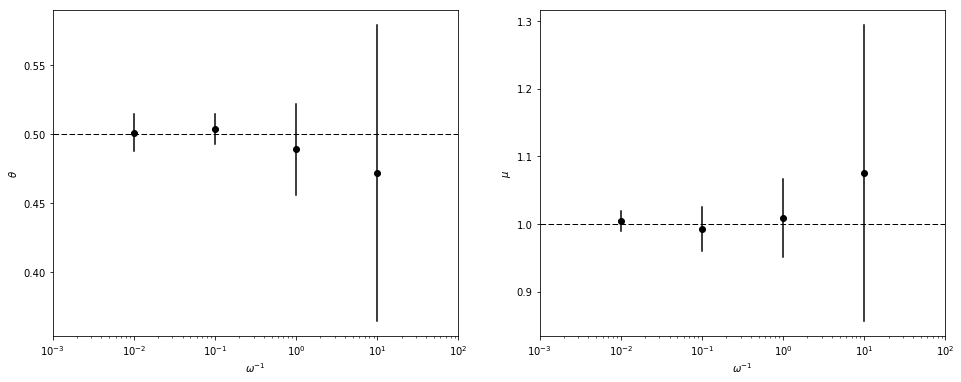

In [29]:
thetas = {key: [result[0][0] for result in all_results_dict[key]] for key in all_results_dict}
mus = {key: [result[0][2] for result in all_results_dict[key]] for key in all_results_dict}

fig, ax = plt.subplots(ncols=2, figsize=(16,6))

plot(ax[0], thetas, 0.5)
plot(ax[1], mus, 1)
ax[0].set(xlabel="$\\omega^{-1}$", ylabel="$\\theta$")
ax[1].set(xlabel="$\\omega^{-1}$", ylabel="$\\mu$")
None

This is definitely an improvement, but despite having tried this a number of times, I cannot reproduce the graphs from Lewis and Mohler.

# Computing the likelihood

From (3) Theorem 3 we know that if $\lambda^*(t)$ is the conditional intensity function, then the likelihood of the process is:

$$ L = \Big( \prod_{i=1}^n \lambda^*(t_i) \Big) \exp\Big( -\int_0^T \lambda^*(s) \ ds \Big) $$

were $(t_1,\cdots,t_n)$ is a sample of the process in the time window $[0,T]$.  Taking logs, this expands to

$$ l = \log L = \sum_{i=1}^n \log\Big( \mu + \sum_{j=1}^{i-1} \theta\omega e^{-\omega (t_i-t_j)} \Big)
- \int_0^T \lambda^*(s) \ ds. $$
The integral can be split into parts:
\begin{align*} \int_0^T \lambda^*(s) \ ds &= \mu T + \sum_{i=1}^{n-1} \int_{t_i}^{t_{i+1}} \sum_{j=1}^i \theta\omega e^{-\omega (t-t_j)} \ dt + \int_{t_n}^T \sum_{j=1}^n \theta\omega e^{-\omega (t-t_j)} \ dt \\
&= \mu T + \theta \sum_{i=1}^{n-1} \sum_{j=1}^i \Big( e^{-\omega (t_i-t_j)} - e^{-\omega (t_{i+1}-t_j)} \Big)
+ \theta \sum_{j=1}^n \Big( e^{-\omega (t_n-t_j)} - e^{-\omega (T-t_j)} \Big)
\end{align*}
Many terms in the double sum cancel out, leaving
\begin{align*}
& \mu T + \theta \sum_{i=1}^{n-1} e^{-\omega (t_i-t_i)} - \theta \sum_{j=1}^{n-1} e^{-\omega (t_n-t_j)}
+ \theta \sum_{j=1}^n \Big( e^{-\omega (t_n-t_j)} - e^{-\omega (T-t_j)} \Big) \\
&= \mu T + n \theta + \theta - \theta \sum_{j=1}^n e^{-\omega (T-t_j)}
\end{align*}

In [30]:
def likelihood(points, time_range, theta, omega, mu):
    n = len(points)
    first_sum = np.empty(n)
    first_sum[0] = mu
    for i in range(1, n):
        dt = points[i] - points[:i]
        first_sum[i] = mu + theta * omega * np.sum(np.exp(-omega * dt))
    second_sum = np.sum(np.exp(-omega * (time_range - points)))
    return np.sum(np.log(first_sum)) - (mu * time_range + n * theta + theta - theta * second_sum)

In [31]:
omega_inv = 10
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=1/omega_inv))
points = process.sample(0, 2000)
convergents = apply_algorithm(points, 2000, 2000, theta_in=0.5, omega_in=1/omega_inv, mu_in=1,
                         convergence_criteria = 10**(-5), func=corrected_m_step)

In [32]:
convergents = np.asarray(convergents)
theta, omega, mu = convergents[:,-1]
theta, omega, mu

(0.27672071286156996, 0.15945568611948427, 1.4167759675794063)

In [33]:
likelihood(points, 2000, theta, omega, mu)

-1279.1097416990806

In [34]:
likelihood(points, 2000, 0.5, 0.1, 1)

-1282.6014507995546

So the algorithm is doing what it should be: finding a maximal likelihood!